In [12]:
import numpy as np
import keras

from keras import layers
from keras import models
from keras.datasets import mnist
from keras.utils import to_categorical
from sklearn.utils import shuffle

from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

keras.__version__

'2.3.1'

In [13]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding = 'same',input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), padding = 'same',activation='relu'))

# In the last but one convolutional layer I use filter size which reduces the output to (None,1,1,Num of filters) 
# See model summary to check that the filter size must be (7,7)
model.add(layers.Conv2D(128, (7,7),activation='relu'))

# in the last convolutional layer use the filter size (1,1) and the number of filters equal to the number of classes. Activation should be 'softmax'
model.add(layers.Conv2D(10, (1,1),activation='softmax'))

# The layer output shape is (None,1,1,10) so I flatten it to (None,10) - I reduce redundant internal dimensions 
model.add(layers.Flatten())

In [14]:
model.summary()

# Check the shape of the last layer output - the train_labels must fit this shape exactly!

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 7, 7, 64)          36928     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 1, 1, 128)         401536    
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 1, 1, 10)         

In [19]:

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)


In [20]:

checkpoint = ModelCheckpoint(
    'model.h5', 
    verbose=1, 
    monitor='val_loss', 
    save_best_only=True
)

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# shuffle the data before k fold validation
train_images, train_labels = shuffle(train_images, train_labels)
k = 5  # k is the number of cross-validations
fold_len = len(train_labels) // k  # fold_len is the number of images with its labels in one fold

all_metrics = []
for i in range(k):
    x_val = train_images[i * fold_len: (i + 1) * fold_len]
    y_val = train_labels[i * fold_len: (i + 1) * fold_len]
    
    x_train = np.concatenate([train_images[:i * fold_len], train_images[(i + 1) * fold_len:]], axis=0)
    y_train = np.concatenate([train_labels[:i * fold_len], train_labels[(i + 1) * fold_len:]], axis=0)
    
    history = model.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_val, y_val), callbacks = [checkpoint])
    mae = history.history['val_accuracy']
    all_metrics.append(mae)
    

Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 60s 1ms/step - loss: 0.0126 - accuracy: 0.9968 - val_loss: 0.0148 - val_accuracy: 0.9956

Epoch 00001: val_loss improved from inf to 0.01480, saving model to model.h5
Epoch 2/5
48000/48000 [==============================] - 59s 1ms/step - loss: 0.0070 - accuracy: 0.9978 - val_loss: 0.0171 - val_accuracy: 0.9962

Epoch 00002: val_loss did not improve from 0.01480
Epoch 3/5
48000/48000 [==============================] - 62s 1ms/step - loss: 0.0062 - accuracy: 0.9984 - val_loss: 0.0194 - val_accuracy: 0.9957

Epoch 00003: val_loss did not improve from 0.01480
Epoch 4/5
48000/48000 [==============================] - 62s 1ms/step - loss: 0.0053 - accuracy: 0.9986 - val_loss: 0.0173 - val_accuracy: 0.9955

Epoch 00004: val_loss did not improve from 0.01480
Epoch 5/5
48000/48000 [==============================] - 63s 1ms/step - loss: 0.0052 - accuracy: 0.9987 - val_loss: 0.0228 - val_acc

In [22]:
mean_accuracies = [np.mean(x) for x in all_metrics]

Text(0, 0.5, 'accuracy')

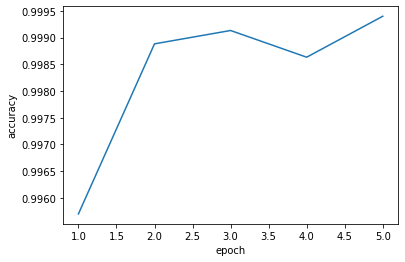

In [26]:
import matplotlib.pyplot as plt

plt.plot([1,2,3,4,5], mean_accuracies)
plt.xlabel("epoch")
plt.ylabel("accuracy")

In [27]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(test_loss,test_acc)

predictions = np.argmax(model.predict(test_images), -1)
true_labels = np.argmax(test_labels, -1)

cm = confusion_matrix(true_labels, predictions)
print(cm)
print(classification_report(true_labels, predictions))


10000/10000 [==============================] - 3s 287us/step
0.07294191011781541 0.9926000237464905
[[ 975    1    0    0    0    1    2    0    0    1]
 [   0 1134    0    0    0    0    1    0    0    0]
 [   0    0 1027    0    0    0    2    3    0    0]
 [   0    1    0 1005    0    3    0    0    0    1]
 [   0    0    0    0  972    0    1    0    0    9]
 [   0    0    0    5    0  886    1    0    0    0]
 [   1    1    0    0    0    4  950    0    2    0]
 [   0    5    2    1    0    0    0 1017    1    2]
 [   2    0    2    2    0    0    0    0  965    3]
 [   0    1    0    0    5    5    0    2    1  995]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       980
           1       0.99      1.00      1.00      1135
           2       1.00      1.00      1.00      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99 